<h2 style="text-align: center;">Lunar Landing using Deep Reinforcement Learning Algorithms</h2>
<h3 style="text-align: center;">Student: Oscar Xu, NetID: KFS2669</h3>

## Ⅰ. Introduction
In this project, we aim to explore and compare the performance of various RL algorithms on the LunarLander-v2 environment from the [OpenAI Gym](https://arxiv.org/abs/1606.01540). The objective of this project is to develop and compare different RL algorithms to solve the LunarLander-v2 problem efficiently and effectively. We will investigate the performance of Q-learning, Monte Carlo, Deep Q-Network (DQN), and DQN with Prioritized Experience Replay (PER) in terms of learning speed, stability, and final performance.

## Ⅱ. Problem Statement
The [LunarLander-v2](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) environment is a classic control problem in which an agent must learn to control a lunar lander spacecraft and safely land it on a designated landing pad. The environment provides a challenging task that requires the agent to make precise adjustments to its thrusters to control its position and velocity while minimizing fuel consumption and avoiding crashing. The environment provides rewards based on the lander's state and actions. <b>Positive rewards</b> are given for <b>successful landing</b>, while <b>negative rewards</b> are given for <b>crashing or using excessive fuel</b>.
<center><img src="https://www.gymlibrary.dev/_images/lunar_lander.gif" height="300" width="300"></center>

## Ⅲ. Dataset
The LunarLander-v2 environment is a simulated environment provided by the OpenAI Gym. This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

### Observation Space
The state space is an 8-dimensional vector, which includes the following variables: 
- x and y coordinates of the lander
- x and y velocities of the lander
- angle and angular velocity of the lander
- left and right leg contact indicators

### Action Space
The action space consists of four discrete actions:
- Do nothing
- Fire left orientation engine
- Fire main engine
- Fire right orientation engine

### Rewards
Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

### Starting State
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

### Episode Termination
The episode finishes if:

- the lander crashes (the lander body gets in contact with the moon);
- the lander gets outside of the viewport (x coordinate is greater than 1);


***

## Ⅳ. Implementation

In [1]:
# !pip install gym==0.22.0 gym[Box2D]==0.22.0 swig torch torchvision numpy matplotlib ipython

In [2]:
# Import necessary libraries and packages
import gym
import imageio
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import deque
from IPython.display import clear_output
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

## Part 1 - Monte Carlo

The Monte Carlo (MC) method for reinforcement learning is used when the model of the environment is unknown. It involves learning from complete episodes of experience without requiring a model of the environment's dynamics. The key idea is to estimate the value (expected return) of each action at a particular state based on many sampled returns following that action from that state.

In [9]:
class MonteCarlo:
    def __init__(self, env, gamma, epsilon, epsilon_min, epsilon_decay):
        # Initializes the Monte Carlo agent with the necessary parameters
        self.env = env                         # environment
        self.gamma = gamma                     # discount factor for future rewards
        self.epsilon = epsilon                 # exploration rate
        self.epsilon_min = epsilon_min         # minimum exploration rate
        self.epsilon_decay = epsilon_decay     # exploration decay rate after each episode
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))   # action-value function
        self.returns_sum = defaultdict(float)  # sum of returns for state-action pairs
        self.returns_count = defaultdict(int)  # count of visits for state-action pairs
        self.state_bins = [
            np.linspace(-1, 1, num=20),   # x position
            np.linspace(-1, 1, num=40),   # y position
            np.linspace(-1, 1, num=10),   # x velocity
            np.linspace(-1, 1, num=10),   # y velocity
            np.linspace(-1, 1, num=10),   # angle
            np.linspace(-1, 1, num=10),   # angular velocity
            np.array([0, 1]),             # left leg contact, binary
            np.array([0, 1])              # right leg contact, binary
        ]

    def discretize_state(self, state):
        # Discretizes the continuous state space into a finite set of bins
        # Each continuous state variable is categorized into a corresponding bin index
        binned_state = []
        for s, bins in zip(state, self.state_bins):
            bin_index = np.digitize(s, bins, right=True)
            bin_index = min(max(bin_index - 1, 0), len(bins) - 1)
            binned_state.append(bin_index)
        return tuple(binned_state)

    def select_action(self, state):
        # Select an action using epsilon-greedy policy
        if np.random.rand() < self.epsilon:           # Explore: random action
            return self.env.action_space.sample()
        else:                                         # Exploit: best known action
            discretized_state = self.discretize_state(state)
            return np.argmax(self.q_table[discretized_state])

    def play_episode(self):
        # Play out one episode and record state, action, and reward.
        episode = []
        state = self.env.reset()
        done = False
        while not done:
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def update_q_values(self, episode):
        # Update Q-values using the first-visit Monte Carlo method
        G = 0
        visited = set()   # to keep track of visited state-action pairs in the episode
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G      # calculate the return
            discretized_state = self.discretize_state(state)
            if (discretized_state, action) not in visited:
                self.returns_sum[(discretized_state, action)] += G
                self.returns_count[(discretized_state, action)] += 1
                self.q_table[discretized_state][action] = self.returns_sum[(discretized_state, action)] / self.returns_count[(discretized_state, action)]
                visited.add((discretized_state, action))

    def train(self, num_episodes):
        # Train the agent over a number of episodes
        episode_rewards = []
        avg_last_10_rewards = []

        for episode in range(num_episodes):
            episode_data = self.play_episode()
            self.update_q_values(episode_data)
            total_reward = sum([x[2] for x in episode_data])
            episode_rewards.append(total_reward)

            if len(episode_rewards) >= 10:
                avg_last_10_rewards.append(np.mean(episode_rewards[-10:]))
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if (episode + 1) % 1000 == 0:
                print(
                    f'Episode: {episode + 1}, Episode Reward: {episode_rewards[-1]}, Average Reward (Latest 10): {avg_last_10_rewards[-1] if avg_last_10_rewards else "N/A"}')
                
        return self.q_table, episode_rewards, avg_last_10_rewards


# Set up the environment and train the agent
print("= = = = = Monte Carlo = = = = =")
env = gym.make('LunarLander-v2')
MC_agent = MonteCarlo(env, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999)
MC_q_table, MC_rewards, MC_avg_rewards = MC_agent.train(num_episodes=10000)
print("= = = = = Training End = = = = =\n")

= = = = = Monte Carlo = = = = =
Episode: 1000, Episode Reward: -108.1975097272285, Average Reward (Latest 10): -112.97164633148402
Episode: 2000, Episode Reward: -68.25885954570694, Average Reward (Latest 10): -83.00799349231686
Episode: 3000, Episode Reward: -62.5068619352191, Average Reward (Latest 10): -82.33929219501564
Episode: 4000, Episode Reward: -95.0737166876222, Average Reward (Latest 10): -69.84570295366527
Episode: 5000, Episode Reward: -41.874075768974095, Average Reward (Latest 10): -56.28372039590552
Episode: 6000, Episode Reward: -59.15485466981124, Average Reward (Latest 10): -47.36263181625993
Episode: 7000, Episode Reward: -8.281375055196463, Average Reward (Latest 10): -35.6786034484859
Episode: 8000, Episode Reward: -90.742370838579, Average Reward (Latest 10): -55.31973658418603
Episode: 9000, Episode Reward: -20.17479023148755, Average Reward (Latest 10): -70.13526796649761
Episode: 10000, Episode Reward: -77.34401405724, Average Reward (Latest 10): -64.00773883

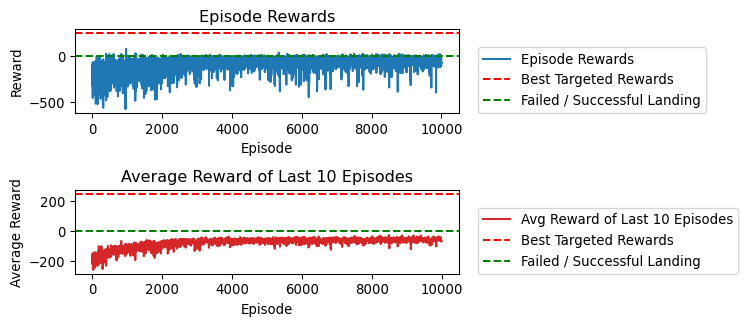

In [132]:
def plot_performance(episode_rewards, avg_last_10_rewards, target):
    # Plots the performance of the agent over episodes
    fig, axs = plt.subplots(2, 1, figsize=(8, 3.5), dpi=96)

    # Plotting the rewards of each episode
    axs[0].plot(episode_rewards, label='Episode Rewards', color='tab:blue')
    axs[0].axhline(y=target, color='r', linestyle='--', label='Best Targeted Rewards')
    axs[0].axhline(y=0, color='g', linestyle='--', label='Failed / Successful Landing')
    axs[0].set_title('Episode Rewards')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    # Plotting the average reward of the last 10 episodes
    axs[1].plot(avg_last_10_rewards, label='Avg Reward of Last 10 Episodes', color='tab:red')
    axs[1].axhline(y=target, color='r', linestyle='--', label='Best Targeted Rewards')
    axs[1].axhline(y=0, color='g', linestyle='--', label='Failed / Successful Landing')
    axs[1].set_title('Average Reward of Last 10 Episodes')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Average Reward')
    axs[1].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    plt.tight_layout()
    plt.show()
    
plot_performance(MC_rewards, MC_avg_rewards, target=250)

In [13]:
import imageio

def create_gif(env, agent, filename):
    frames = []
    state = env.reset()
    img = env.render(mode='rgb_array')
    frames.append(img)
    done = False
    while not done:
        discretized_state = agent.discretize_state(state)
        action = np.argmax(agent.q_table[discretized_state])
        state, _, done, _ = env.step(action)
        img = env.render(mode='rgb_array')
        frames.append(img)

    imageio.mimsave(filename, frames, fps=30)

# Create the Gif
create_gif(env, MC_agent, filename='1.Monte-Carlo.gif')

## Part 2 - Q-learning

Q-learning is a model-free reinforcement learning algorithm that solves decision-making problems by learning an action-value function that gives the expected utility of taking a given action in a given state and following a fixed policy thereafter.
- Initialization: Start with a Q-table that holds expected rewards for state-action pairs, initially set to zero or some small random values.
- Learning by Interaction: The agent interacts with the environment by choosing actions based on current Q-values, observes rewards, and transitions into new states.
- Update Rule: After each action, update the Q-values in the Q-table using the formula ($\alpha$ is the learning rate, $\gamma$ the discount factor):
  $$Q(s', a) \gets (1 - \alpha) \cdot Q(s, a) + \alpha \cdot (r + \gamma \cdot \max_{a'} Q(s', a'))$$
  

In [15]:
class QLearning:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        # Initialize the Q-learning agent with the environment and learning parameters
        self.env = env
        self.alpha = alpha                  # Learning rate
        self.gamma = gamma                  # Discount factor
        self.epsilon = epsilon              # Exploration rate
        self.epsilon_min = epsilon_min      # Minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for exploration
        self.num_bins = (20, 40, 10, 10, 10, 10, 2, 2)  # State bins for discretization
        self.q_table = np.zeros(self.num_bins + (env.action_space.n,))  # Initialize Q-table
        self.state_bins = [
            np.linspace(-1, 1, num=20),  # x position
            np.linspace(-1, 1, num=40),  # y position
            np.linspace(-1, 1, num=10),  # x velocity
            np.linspace(-1, 1, num=10),  # y velocity
            np.linspace(-1, 1, num=10),  # angle
            np.linspace(-1, 1, num=10),  # angular velocity
            np.array([0, 1]),            # left leg contact, binary
            np.array([0, 1])             # right leg contact, binary
        ]
        self.last_episode_frames = []  

    def discretize_state(self, state):
        # Converts continuous state variables into discretized indices based on bins
        return tuple(
            min(len(self.state_bins[i]) - 1, np.digitize(state[i], self.state_bins[i]) - 1) for i in range(len(state)))

    def select_action(self, state):
        # Select an action using the epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Explore: random action
        else:
            return np.argmax(self.q_table[state])  # Exploit: best known action

    def play_episode(self, max_steps_per_episode):
        # Simulate one complete episode using the current policy
        state = self.discretize_state(self.env.reset())
        total_reward = 0
        episode_data = []

        for _ in range(max_steps_per_episode):
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            next_state = self.discretize_state(next_state)
            episode_data.append((state, action))
            total_reward += reward
            
            # # Q-value update using the learning rate (alpha) and discount factor (gamma)
            self.q_table[state][action] += self.alpha * (
                        reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state][action])
            state = next_state
            if done:
                break
                
        return total_reward

    def train(self, num_episodes, max_steps_per_episode):
        # Main training function for the Q-learning agent
        episode_rewards = []
        avg_last_10_rewards = []
        epsilons = []

        for episode in range(num_episodes):
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)
            total_reward = self.play_episode(max_steps_per_episode)
            epsilons.append(total_reward)
            episode_rewards.append(total_reward)

            if len(episode_rewards) >= 10:
                avg_last_10_rewards.append(np.mean(episode_rewards[-10:]))

            # Output training progress
            if (episode + 1) % 1000 == 0:
                print(
                    f'Episode: {episode + 1}, Episode Reward: {episode_rewards[-1]}, Average Reward (Latest 10): {avg_last_10_rewards[-1] if avg_last_10_rewards else "N/A"}')

        return self.q_table, epsilons, avg_last_10_rewards
        

# Initialize the environment and Q-table
print("= = = = = Q-Learning = = = = =")
env = gym.make("LunarLander-v2")
QL_agent = QLearning(env, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_min=0.001, epsilon_decay=0.995)
QL_q_table, QL_rewards, QL_avg_rewards = QL_agent.train(num_episodes=10000, max_steps_per_episode=100)
print("= = = = = Training End = = = = =\n")

= = = = = Q-Learning = = = = =
Episode: 1000, Episode Reward: -170.69414271530314, Average Reward (Latest 10): -24.802084877012337
Episode: 2000, Episode Reward: -16.750016362135568, Average Reward (Latest 10): 13.224474518892311
Episode: 3000, Episode Reward: 8.277748346839392, Average Reward (Latest 10): 20.502540825751513
Episode: 4000, Episode Reward: 9.374715545931911, Average Reward (Latest 10): 16.88751367722775
Episode: 5000, Episode Reward: 15.628032096232126, Average Reward (Latest 10): 23.379796064013608
Episode: 6000, Episode Reward: 13.639003353845155, Average Reward (Latest 10): 14.433727677601865
Episode: 7000, Episode Reward: 7.055518276559059, Average Reward (Latest 10): 22.45894178567198
Episode: 8000, Episode Reward: -7.995788412535755, Average Reward (Latest 10): 21.74413735806663
Episode: 9000, Episode Reward: 40.514229882415, Average Reward (Latest 10): 45.61121008679724
Episode: 10000, Episode Reward: 86.18557149805869, Average Reward (Latest 10): 28.951580070723

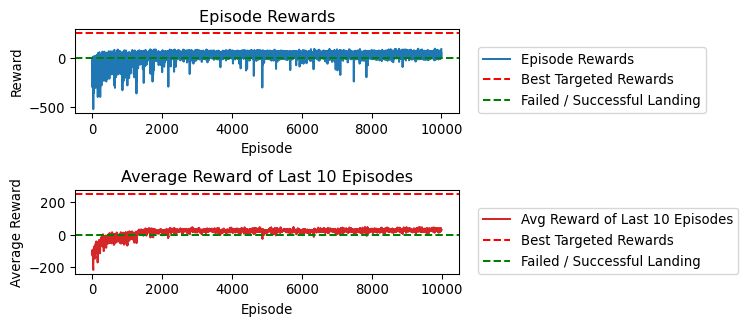

In [133]:
plot_performance(QL_rewards, QL_avg_rewards, target=250)

In [17]:
# Create the Gif
create_gif(env, QL_agent, filename='2.Q-Learning.gif')

## Part 3 - Deep Q-Network (DQN)

The Deep Q-Network (DQN) algorithm is a breakthrough in reinforcement learning that was first introduced by researchers at DeepMind in 2015. DQN combines Q-learning, a type of temporal difference (TD) learning, with deep neural networks.

- Neural Network Architecture: Instead of a traditional Q-table, DQN uses a neural network to approximate the Q-value function. The input to the network is the state of the environment, and the output is the estimated Q-values for each possible action.
- Random Experience Replay: To break the correlation between consecutive samples and to make use of past experiences, DQN stores the agent's experiences at each time step in a data structure called the replay buffer. Each experience is stored as a tuple (state, action, reward, next_state, done). Training samples are then randomly drawn from this buffer.
- Fixed Q-Targets: To stabilize training, DQN uses two networks: a policy network and a target network. The policy network is used to select actions, and the target network is used to generate the Q-value targets for training the policy network. Periodically, the weights of the policy network are copied to the target network to stabilize the learning updates.

In [19]:
# Neural network model
class DQN(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(DQN, self).__init__()             # Initialize the nn.Module parent class
        self.seed = torch.manual_seed(seed)     # Set the seed for generating random numbers
        self.fc1 = nn.Linear(state_size, 128)   # Input layer to first hidden layer
        self.fc2 = nn.Linear(128, 128)          # Second hidden layer
        self.fc3 = nn.Linear(128, action_size)  # Output layer

    def forward(self, state):
        x = F.relu(self.fc1(state))             # First layer activation
        x = F.relu(self.fc2(x))                 # Second layer activation
        return self.fc3(x)                      # Output layer, returns Q-values for each action

# Environment setup
env = gym.make("LunarLander-v2")
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]

# Instantiate the model
model = DQN(num_states, num_actions, seed=0)
target_model = DQN(num_states, num_actions, seed=0)
target_model.load_state_dict(model.state_dict())
target_model.eval()

# Set optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
# Random Experience replay buffer
replay_buffer = deque(maxlen=1000000)

# Function to sample a batch from the replay buffer
def sample_batch(batch_size):
    batch = random.sample(replay_buffer, batch_size)
    state, action, reward, next_state, done = zip(*batch)
    return (np.array(state), np.array(action), np.array(reward, dtype=np.float32),
            np.array(next_state), np.array(done, dtype=np.float32))

# Function to train a DQN agent
def train_agent(env, model, target_model, gamma, epsilon, epsilon_min, epsilon_decay, batch_size, max_steps_per_episode,
                num_episodes, update_every, target):
    episode_rewards = []               # List to store total rewards per episode
    losses = []                        # List to store average losses per episode
    avg_last_10_rewards = []           # List to store average rewards of the last 10 episodes
    epsilons = []                      # List to store epsilon values over episodes
    training_start_time = time.time()  # Start timing the training session
    first_reached_target = False       # Flag to check if avg last 10 rewards reaches target
    time_to_reach_target = None

    # Loop over each episode
    for episode in range(num_episodes):
        state = env.reset()            # Reset the environment and get initial state
        total_reward = 0               # Initialize total reward for the episode
        episode_losses = []            # List to store losses per episode

        # Loop for each step in the episode
        for step in range(max_steps_per_episode):
            # Epsilon-greedy policy: select random action or best action based on epsilon
            if random.random() < epsilon:
                action = env.action_space.sample()           # Choose a random action
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
                with torch.no_grad():
                    action_values = model(state_tensor)      # Get action values from model
                action = torch.argmax(action_values).item()  # Choose best action

            # Take action in environment and observe next state and reward
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            replay_buffer.append((state, action, reward, next_state, done))  # Store transition in replay buffer
            state = next_state  # Update state to next state

            # If replay buffer has enough samples, perform a training step
            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = sample_batch(batch_size)  # Sample a batch
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Compute current Q values from model
                current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                # Compute next Q values from target model (for stability)
                next_q_values = target_model(next_states).max(1)[0]
                # Compute expected Q values
                expected_q_values = rewards + gamma * next_q_values * (1 - dones)
                # Compute loss
                loss = loss_fn(current_q_values, expected_q_values.detach())
                # Gradient descent step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

            if done:
                break  # Exit loop if episode is done

        # Update epsilon using decay rate (reduce as training progresses)
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        epsilons.append(epsilon)  # Append epsilon to list

        # Log rewards and losses
        episode_rewards.append(total_reward)
        if len(episode_rewards) >= 10:
            avg_last_10_rewards.append(np.mean(episode_rewards[-10:]))   # Average of last 10 episodes
            if avg_last_10_rewards[-1] >= target and not first_reached_target:
                first_reached_target = True
                time_to_reach_target = time.time() - training_start_time
        losses.append(np.mean(episode_losses))   # Average loss for this episode

        # Update target network every 10 episodes
        if (episode + 1) % update_every == 0:
            target_model.load_state_dict(model.state_dict())

        # Print log info every 100 episodes
        if (episode + 1) % 100 == 0:
            print(
                f'Episode: {episode + 1}, Episode Reward: {episode_rewards[-1]}, Average Reward (Latest 10): {avg_last_10_rewards[-1] if avg_last_10_rewards else "N/A"}, Average Loss: {np.mean(episode_losses)}')

    # Print time
    if time_to_reach_target is not None:
        print(f"\nAverage latest 10 rewards reached {target} for the first time at {time_to_reach_target:.2f} seconds.")
    else: print(f"\nFailed to meet the Target Rewards = 250.")
    total_training_time = time.time() - training_start_time  # Calculate total training time
    print(f"Total training time: {total_training_time:.2f} seconds.")

    return model, episode_rewards, avg_last_10_rewards, episode_losses, epsilons


print("= = = = = Deep Q-Network (DQN) = = = = =")
# Train the agent
DQN_trained_model, DQN_rewards, DQN_avg_rewards, DQN_losses, DQN_epsilons = train_agent(
    env,                  # The Gym environment, "LunarLander-v2" in this case
    model,                # The neural network model to be trained
    target_model,         # A separate network used for calculating target Q-values to stabilize training
    gamma=0.99,           # Discount factor for past rewards, determines how much future rewards are considered
    epsilon=1.0,          # Initial exploration rate; the probability of selecting a random action over the best known action
    epsilon_min=0.001,    # Minimum value to which epsilon can decay, ensuring some level of exploration
    epsilon_decay=0.995,  # Multiplicative factor for decreasing epsilon, controls the rate of exploration decay
    batch_size=64,        # Number of experiences to sample from memory during each training step
    max_steps_per_episode=500,  # Maximum number of steps per episode, prevents any episode from running too long
    num_episodes=1000,    # Total number of episodes to train across
    update_every=10,      # Frequency of updating the target network with the model's weights
    target = 250
)
print("= = = = = Training End = = = = =\n")

= = = = = Deep Q-Network (DQN) = = = = =
Episode: 100, Episode Reward: -57.25568085750254, Average Reward (Latest 10): -57.87402280329866, Average Loss: 39.75535768373853
Episode: 200, Episode Reward: 91.47209774799786, Average Reward (Latest 10): -5.162477396793612, Average Loss: 19.915673458099366
Episode: 300, Episode Reward: -20.243882780852616, Average Reward (Latest 10): -39.93657616451903, Average Loss: 15.566555087301467
Episode: 400, Episode Reward: 67.54806128415963, Average Reward (Latest 10): 26.972051085493348, Average Loss: 11.026633188962936
Episode: 500, Episode Reward: 27.541659407647458, Average Reward (Latest 10): 58.145775866831, Average Loss: 11.936707534074783
Episode: 600, Episode Reward: 81.7175942391616, Average Reward (Latest 10): 155.91785108903284, Average Loss: 9.145731981158256
Episode: 700, Episode Reward: 252.77136681905486, Average Reward (Latest 10): 189.35338603216326, Average Loss: 7.9857665533533435
Episode: 800, Episode Reward: 220.42245767795544, 

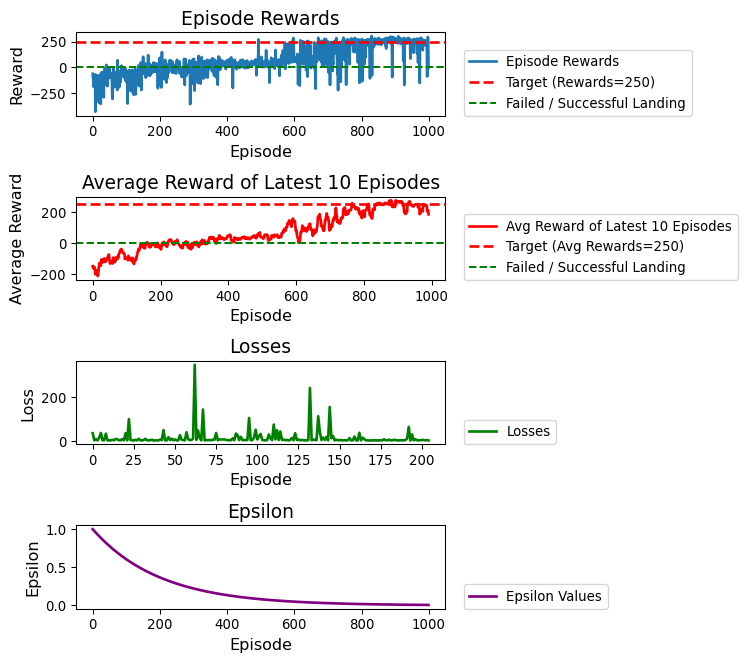

In [96]:
# Plots the performance of the agent over episodes
colors = ['tab:blue', 'red', 'green', 'purple']
def plot_performance_NN(episode_rewards, avg_last_10_rewards, losses, epsilons, target):
    fig, axs = plt.subplots(4, 1, figsize=(8, 7), dpi=96) 

    # Plotting Episode Rewards
    axs[0].plot(episode_rewards, label='Episode Rewards', color=colors[0], linewidth=2)
    axs[0].axhline(y=250, color='r', linestyle='--', linewidth=2, label=f'Target (Rewards={target})')
    axs[0].axhline(y=0, color='g', linestyle='--', label='Failed / Successful Landing')
    axs[0].set_title('Episode Rewards', fontsize=14)
    axs[0].set_xlabel('Episode', fontsize=12)
    axs[0].set_ylabel('Reward', fontsize=12)
    axs[0].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    # Plotting Average Reward of Last 10 Episodes
    axs[1].plot(avg_last_10_rewards, label='Avg Reward of Latest 10 Episodes', color=colors[1], linewidth=2)
    axs[1].axhline(y=250, color='r', linestyle='--', linewidth=2, label=f'Target (Avg Rewards={target})')
    axs[1].axhline(y=0, color='g', linestyle='--', label='Failed / Successful Landing')
    axs[1].set_title('Average Reward of Latest 10 Episodes', fontsize=14)
    axs[1].set_xlabel('Episode', fontsize=12)
    axs[1].set_ylabel('Average Reward', fontsize=12)
    axs[1].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    # Plotting Losses
    axs[2].plot(losses, label='Losses', color=colors[2], linewidth=2)
    axs[2].set_title('Losses', fontsize=14)
    axs[2].set_xlabel('Episode', fontsize=12)
    axs[2].set_ylabel('Loss', fontsize=12)
    axs[2].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    # Plotting Epsilon values
    axs[3].plot(epsilons, label='Epsilon Values', color=colors[3], linewidth=2)
    axs[3].set_title('Epsilon', fontsize=14)
    axs[3].set_xlabel('Episode', fontsize=12)
    axs[3].set_ylabel('Epsilon', fontsize=12)
    axs[3].legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

plot_performance_NN(DQN_rewards, DQN_avg_rewards, DQN_losses, DQN_epsilons, target=250)

In [31]:
import imageio

def create_gif(env, model, filename, num_episodes=1, max_steps_per_episode=500):
    env = gym.make("LunarLander-v2")
    frames = []
    for episode in range(num_episodes):
        state = env.reset()
        for _ in range(max_steps_per_episode):
            frames.append(env.render(mode="rgb_array"))  # Capture RGB frames for GIF
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = model(state_tensor)
            action = torch.argmax(action_values).item()
            state, _, done, _ = env.step(action)
            if done:
                break
        env.close()
    
    # Save frames as a GIF
    imageio.mimsave(filename, frames, fps=30)

# Generate and save the GIF
create_gif(env, DQN_trained_model, '3.DQN.gif')

## Part 4 - Deep Q-Network (DQN) with Prioritized Experience Replay (PER)

Prioritized Experience Replay (PER) is a technique used to enhance the learning process of reinforcement learning algorithms, particularly those based on Q-learning.

- Traditional experience replay techniques involve storing transition experiences in a replay buffer and then randomly sampling from this buffer to train the agent. This random sampling treats all experiences as equally important for learning. However, not all experiences are equally valuable; some may contain crucial information about how to perform specific actions in given states that are pivotal for learning effective policies.

- PER introduces a mechanism to <b>prioritize experiences based on their temporal difference (TD) error</b>, which is a measure of the surprise or the learning potential of an experience. The TD error essentially quantifies how unexpected the outcome of an action was based on the current policy and value estimation. Higher TD errors indicate greater discrepancies between expected and actual outcomes, suggesting that the agent has much to learn from that particular experience.

- In "LunarLander-v2", where the agent must learn to land a spacecraft safely on a landing pad, certain situations, such as managing high velocity near the landing pad or correcting an unstable descent, are more challenging. These situations often generate higher TD errors because the agent's predictions are less accurate. PER ensures that such experiences are sampled more frequently, allowing the agent to practice and learn from these critical scenarios more often.

In [33]:
# Neural network model
class DQN(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(DQN, self).__init__()  # Initialize the nn.Module parent class
        self.seed = torch.manual_seed(seed)  # Set the seed for generating random numbers
        self.fc1 = nn.Linear(state_size, 128)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(128, 128)  # Second hidden layer
        self.fc3 = nn.Linear(128, action_size)  # Output layer

    def forward(self, state):
        x = F.relu(self.fc1(state))  # First layer activation
        x = F.relu(self.fc2(x))  # Second layer activation
        return self.fc3(x)  # Output layer, returns Q-values for each action
        
# A binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0

    # Recursive function to update tree values
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)
            
    # Update the value at index 'idx' with 'priority'
    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    # Add a new data point with priority into the tree
    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
            
    # Get a leaf node based on value 's'
    def get_leaf(self, s):
        idx = 0
        while idx < self.capacity - 1:
            left = 2 * idx + 1
            right = left + 1
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        return idx, self.tree[idx], self.data[idx - self.capacity + 1]

    # Return the total priority sum
    def total_priority(self):
        return self.tree[0]

# Implementation of the prioritized replay buffer
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.02):
        self.tree = SumTree(capacity)
        self.alpha = alpha

    def add(self, error, sample):
        priority = (np.abs(error) + 1e-5) ** self.alpha
        self.tree.add(priority, sample)

    def sample(self, n):
        batch = []
        segment = self.tree.total_priority() / n
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            batch.append((idx, p, data))
        return batch

    def update(self, idx, error):
        priority = (np.abs(error) + 1e-5) ** self.alpha
        self.tree.update(idx, priority)

# Compute Temporal Difference (TD) error for updating priorities
def compute_td_error(model, target_model, states, actions, rewards, next_states, dones, gamma):
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    # Perform forward passes on both the model and target_model to compute Q-values
    with torch.no_grad():
        # Compute Q-values of the current states using the model
        current_q_values = model(states).gather(1, actions).squeeze(1)
        # Compute Q-values of the next states using the target_model and select the maximum Q-value for each next state
        next_q_values = target_model(next_states).max(1)[0]
        # Calculate expected Q-values using the Bellman equation: Q(s,a) = r + γ * max(Q(s',a')) * (1 - done)
        expected_q_values = rewards + gamma * next_q_values * (1 - dones)
        # Calculate the absolute TD errors (|Q(s,a) - Q_target(s,a)|)
        errors = torch.abs(current_q_values - expected_q_values).numpy()

    # Return the computed TD errors as a NumPy array
    return errors


# Environment setup
env = gym.make("LunarLander-v2")
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]

# Instantiate the model and the optimizer
model = DQN(num_states, num_actions, seed=0)
target_model = DQN(num_states, num_actions, seed=0)
target_model.load_state_dict(model.state_dict())
target_model.eval()

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
buffer = PrioritizedReplayBuffer(capacity=1000000)

# Main training loop for training the agent using DQN with Prioritized Experience Replay
def train_agent(env, model, target_model, gamma, epsilon, epsilon_min, epsilon_decay, batch_size, num_episodes,
                max_steps_per_episode, update_every, target):
    episode_rewards = []               # List to store rewards obtained in each episode
    avg_last_10_rewards = []           # List to store average rewards of last 10 episodes
    epsilons = []                      # List to store epsilon values for epsilon-greedy exploration
    frame_idx = 0                      # Counter to track the total number of frames processed
    losses = []                        # List to store average losses per episode
    training_start_time = time.time()  # Start timing the training session
    first_reached_target = False       # Flag to check if avg last 10 rewards reaches target
    time_to_reach_target = None        # Variable to track time taken to reach target

    # Loop over episodes
    for episode in range(num_episodes):
        state = env.reset()            # Reset the environment and get initial state
        state = torch.FloatTensor(state).unsqueeze(0)  # Move initial state to CPU
        total_reward = 0               # Initialize total reward for the episode
        episode_losses = []            # List to store losses for the current episode

        # Loop over steps within the episode
        for t in range(max_steps_per_episode):
            frame_idx += 1  # Increment frame index

            # Epsilon-greedy action selection
            if random.random() > epsilon:
                with torch.no_grad():
                    action_values = model(state)
                action = action_values.max(1)[1].view(1, 1).item()  # Select action
            else:
                action = env.action_space.sample()  # Choose random action for exploration

            # Take action in the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward  # Accumulate reward for the episode
            next_state = torch.FloatTensor(next_state).unsqueeze(0)  # Move next state to CPU
            reward = torch.FloatTensor([reward])  # Move reward to CPU
            done = torch.FloatTensor([done])  # Move done flag to CPU

            # Calculate TD error for priority
            with torch.no_grad():
                current_q = model(state).gather(1, torch.LongTensor([[action]])).squeeze(1)
                next_q = target_model(next_state).max(1)[0]
                expected_q = reward + gamma * next_q * (1 - done)
                error = abs(current_q - expected_q).item()

            # Store the experience in buffer with priority
            buffer.add(error,
                       (state.numpy(), action, reward.item(), next_state.numpy(), done.item()))

            # Sample experiences from the buffer for training
            if frame_idx > batch_size:
                sampled_experiences = buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*[data for _, _, data in sampled_experiences])
                idxs = [idx for idx, _, _ in sampled_experiences]
                states = torch.FloatTensor(np.array(states)).squeeze(1)
                actions = torch.LongTensor(np.array(actions)).unsqueeze(1)
                rewards = torch.FloatTensor(np.array(rewards))
                next_states = torch.FloatTensor(np.array(next_states)).squeeze(1)
                dones = torch.FloatTensor(np.array(dones))

                # Forward pass
                current_qs = model(states).gather(1, actions).squeeze(1)
                next_qs = target_model(next_states).max(1)[0]
                target_qs = rewards + (gamma * next_qs * (1 - dones))

                # Compute loss
                loss = loss_fn(current_qs, target_qs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update priorities in the buffer
                new_errors = compute_td_error(model, target_model, states.numpy(),
                                              actions.squeeze(1).numpy(),
                                              rewards.numpy(), next_states.numpy(), dones.numpy(),
                                              gamma)
                for i in range(batch_size):
                    buffer.update(idxs[i], new_errors[i])

                episode_losses.append(loss.item())

            # Update target network every 'update_every' steps
            if frame_idx % update_every == 0:
                target_model.load_state_dict(model.state_dict())

            if done:  # If episode is done, exit the loop
                break
            state = next_state  # Update state for the next step

        epsilon = max(epsilon_min, epsilon_decay * epsilon)  # Reduce epsilon for exploration
        epsilons.append(epsilon)  # Store epsilon value for monitoring
        episode_rewards.append(total_reward)  # Store total reward obtained in the episode

        # Calculate and store average rewards of last 10 episodes
        if len(episode_rewards) >= 10:
            avg_last_10_rewards.append(np.mean(episode_rewards[-10:]))
            # Check if target average reward is reached for the first time
            if avg_last_10_rewards[-1] >= target and not first_reached_target:
                first_reached_target = True
                time_to_reach_target = time.time() - training_start_time

        losses.append(np.mean(episode_losses))  # Average loss for this episode

        # Print episode statistics every 100 episodes
        if (episode + 1) % 100 == 0:
            print(
                f'Episode: {episode + 1}, Episode Reward: {episode_rewards[-1]}, Average Reward (Latest 10): {avg_last_10_rewards[-1] if avg_last_10_rewards else "N/A"}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

    # Print time
    if time_to_reach_target is not None:
        print(f"\nAverage latest 10 rewards reached {target} for the first time at {time_to_reach_target:.2f} seconds.")
    else: print(f"\nFailed to meet the Target Rewards = 250.")
    total_training_time = time.time() - training_start_time  # Calculate total training time
    print(f"Total training time: {total_training_time:.2f} seconds.")

    return model, episode_rewards, avg_last_10_rewards, episode_losses, epsilons


print("= = = = = Deep Q-Network (DQN) with Prioritized Experience Replay (PER) = = = = =")
# Train the agent
DQN_PER_trained_model, DQN_PER_rewards, DQN_PER_avg_rewards, DQN_PER_losses, DQN_PER_epsilons  = train_agent(
    env,                 # Environment (OpenAI Gym environment) where the agent interacts
    model,               # DQN model used by the agent for learning
    target_model,        # Target network used for computing target Q-values
    gamma=0.99,          # Discount factor (γ) for future rewards in the Bellman equation
    epsilon=1.0,         # Initial exploration rate for epsilon-greedy action selection
    epsilon_min=0.001,   # Minimum exploration rate
    epsilon_decay=0.995, # Decay rate for reducing exploration rate over time
    batch_size=64,       # Batch size for sampling experiences from the replay buffer
    num_episodes=1000,   # Total number of episodes for training
    max_steps_per_episode=500,  # Maximum number of steps allowed per episode
    update_every=10,     # Frequency of updating the target network with the model's weights
    target=250
)
print("= = = = = Training End = = = = =\n")

= = = = = Deep Q-Network (DQN) with Prioritized Experience Replay (PER) = = = = =
Episode: 100, Episode Reward: -135.22665985341743, Average Reward (Latest 10): -286.85556205396796, Average Loss: 163.94106008651409
Episode: 200, Episode Reward: -13.752925690038367, Average Reward (Latest 10): -8.271299313877979, Average Loss: 30.11112186071035
Episode: 300, Episode Reward: 54.37847587043433, Average Reward (Latest 10): 39.78300344246582, Average Loss: 28.972130243778228
Episode: 400, Episode Reward: 164.15074602570292, Average Reward (Latest 10): 96.55552767063394, Average Loss: 23.791082802057268
Episode: 500, Episode Reward: 220.54924005456337, Average Reward (Latest 10): 163.92258895789658, Average Loss: 22.382371068409043
Episode: 600, Episode Reward: 116.6510279631266, Average Reward (Latest 10): 208.75819811684883, Average Loss: 16.944977588415146
Episode: 700, Episode Reward: 270.41456269881894, Average Reward (Latest 10): 263.39671379078425, Average Loss: 17.511775741359127
Epi

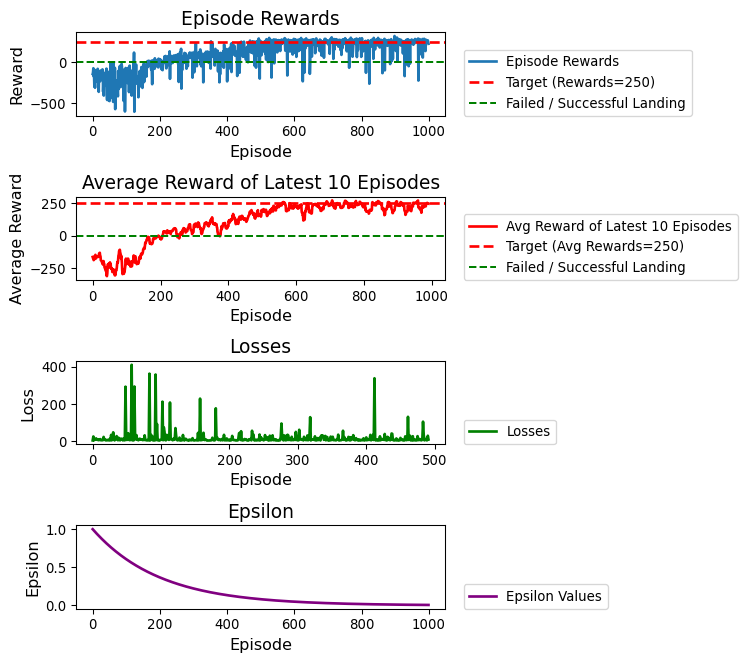

In [97]:
plot_performance_NN(DQN_PER_rewards, DQN_PER_avg_rewards, DQN_PER_losses, DQN_PER_epsilons, target=250)

In [42]:
# Generate and save the GIF
create_gif(env, DQN_PER_trained_model, '4.DQN-PER.gif')

## Ⅴ. Results

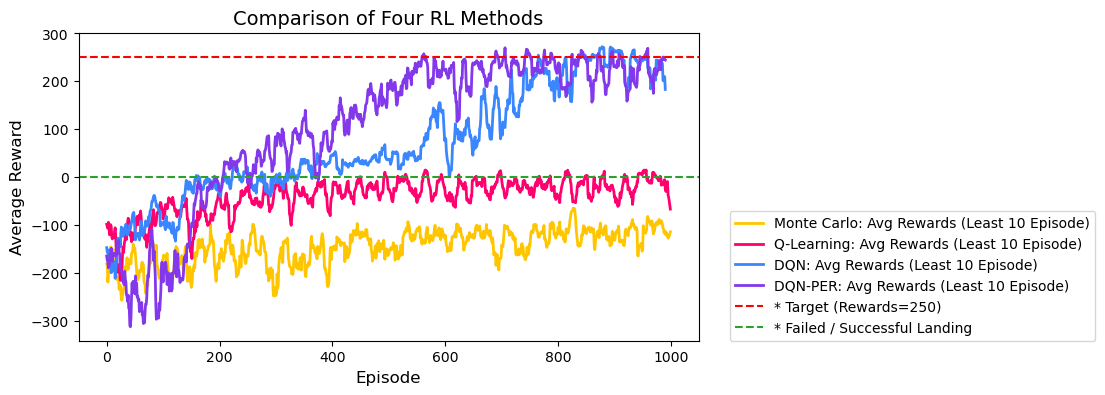

In [136]:
# Plots the performance of the agent over episodes
colors = ['#ffc600', '#ff006e','#3a86ff', '#8338ec']
def plot_performance_compare(MC_avg, QL_avg, DQN_avg, DQN_PER_avg, target):
    fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=100) 

    # Plotting Episode Rewards
    axs.plot(MC_avg[:1000], label='Monte Carlo: Avg Rewards (Least 10 Episode)', color=colors[0], linewidth=2)
    axs.plot(QL_avg[:1000], label='Q-Learning: Avg Rewards (Least 10 Episode)', color=colors[1], linewidth=2)
    axs.plot(DQN_avg, label='DQN: Avg Rewards (Least 10 Episode)', color=colors[2], linewidth=2)
    axs.plot(DQN_PER_avg, label='DQN-PER: Avg Rewards (Least 10 Episode)', color=colors[3], linewidth=2)
    axs.set_title('Comparison of Four RL Methods', fontsize=14)
    axs.set_xlabel('Episode', fontsize=12)
    axs.set_ylabel('Average Reward', fontsize=12)

    axs.axhline(y=250, color='r', linestyle='--', label=f'* Target (Rewards={target})')
    axs.axhline(y=0, color='tab:green', linestyle='--', label='* Failed / Successful Landing')
    axs.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

    plt.show()

plot_performance_compare(MC_avg_rewards, QL_avg_rewards, DQN_avg_rewards, DQN_PER_avg_rewards, target=250)

- <b>Monte Carlo</b>: Shown in yellow, the Monte Carlo method has the lowest performance among the four. It shows an overall trend of increasing reward but remains below zero throughout the episodes, indicating less effective learning in this context. <b>(Mission failed)</b>

- <b>Q-Learning</b>: The pink line represents Q-Learning. Similar to Monte Carlo, its performance fluctuates and generally stays below zero, suggesting limited success in solving the LunarLander-v2 environment effectively. <b>(Mission at the edge)</b>

- <b>DQN (Deep Q-Network)</b>: Represented by the blue line, the DQN method demonstrates significant improvement over Monte Carlo and Q-Learning. It trends upward strongly and surpasses the zero reward threshold early on, maintaining a performance generally above this baseline, which suggests better learning and problem-solving capability.<b>(Mission succeed)</b>

- <b>DQN-PER (Deep Q-Network with Prioritized Experience Replay)</b>: The purple line indicates the DQN-PER, which shows a pattern similar to the standard DQN but with slightly higher variability. It also trends above the zero reward threshold for much of its trajectory, reflecting effective learning adjustments provided by the prioritized replay mechanism.<b>(Mission succeed)</b>

## Ⅵ. Q & A

#### 1. How do the algorithms perform in terms of training time?

For Monte Carlo and Q-Learning, the training is quite fast, taking only about 1-2 minutes each. For the DQN and DQN-PER, which are more computationally demanding, the training time extends to about 5-10 minutes, as I monitored through timing functions in my code.

#### 2. How close are the results to the expected results?

I didn't set specific expectations beforehand. However, I am genuinely impressed by the feature extraction capabilities of neural networks. Both DQN and DQN-PER, which share the same reinforcement learning mechanism, significantly outperformed the traditional Q-Learning approach.

#### 3. How did you adjust the parameters of your algorithm to solve the problem?

I relied primarily on trial and error to fine-tune the parameters. This iterative process helped me understand how different settings impacted the model's performance and stability.

#### 4. What parameters played an important role in solving the problem?

Critical parameters included the learning rate (alpha), discount factor (gamma), initial exploration rate (epsilon), minimum exploration rate (epsilon_min), and the exploration decay rate (epsilon_decay). Other significant factors were the batch size (batch_size), number of training episodes (episode_num), maximum steps per episode (maximum_steps_per_episode), frequency of network updates (update_every), and the architecture of the neural networks (Different Layers and Activation Functions). All these parameters significantly influenced the outcomes of my experiments.

#### 5. What were the challenges when working with the algorithms?

The primary challenges I faced were fine-tuning the parameters to optimize performance and managing the computing power. My laptop struggled with the demands of training DQN and DQN-PER, often overheating during longer training sessions.

#### 6. How could you improve your results with future work?

I plan to enhance computing efficiency by learning and utilizing CUDA for GPU acceleration. This should allow me to conduct more extensive experiments and iterate on model adjustments more quickly in future work.


---

Finished here